# Dataset analysis

## Load and prepare

In [1]:
import matplotlib.pyplot as plt
import itertools
from collections import Counter

In [2]:
import pandas as pd

In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer

In [4]:
dataset_id = "ag_news"
dataset = load_dataset(dataset_id)
dataset

Using custom data configuration default
Reusing dataset ag_news (/Users/emiliomarinone/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [5]:
label_class = dataset["train"].features["label"]
label_names = label_class.names
label_names

['World', 'Sports', 'Business', 'Sci/Tech']

In [6]:
dataset.set_format(type="pandas")

In [7]:
train_df = dataset["train"][:]
print("Original", train_df.shape)
train_df.drop_duplicates(inplace=True)
print("Dropped duplicates", train_df.shape)
train_df.head()

Original (120000, 2)
Dropped duplicates (120000, 2)


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [8]:
test_df = dataset["test"][:]
print("Original", test_df.shape)
test_df.drop_duplicates(inplace=True)
print("Dropped duplicates", test_df.shape)
test_df.head()

Original (7600, 2)
Dropped duplicates (7600, 2)


,text,label
0,Fears for T N pension after talks Unions repre...,2
1,The Race is On: Second Private Team Sets Launc...,3
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3


In [9]:
def label_to_str(row):
    return label_class.int2str(row)

In [10]:
train_df["label_name"] = train_df["label"].apply(label_to_str)
test_df["label_name"] = test_df["label"].apply(label_to_str)

In [11]:
train_df.sample(5)

,text,label,label_name
106701,The biggest game of the year I look at quot;G...,3,Sci/Tech
50829,SpaceShipOne Wins #36;10 Million Prize with F...,3,Sci/Tech
25760,Pentagon Revives Memory Project The Department...,3,Sci/Tech
54725,Samsung driving forward With its shipments jum...,3,Sci/Tech
44538,Jordan Acts to Curb a Rising Chorus of Critics...,0,World


In [12]:
test_df.sample(5)

,text,label,label_name
3748,"Warrick doubtful for Sunday Cincinnati, OH (Sp...",1,Sports
2828,IBM Claims Its BlueGene Supercomputer Is the F...,2,Business
4763,A fresh look at the stars... A supernova spott...,3,Sci/Tech
1876,TV war puts tour of India in doubt Australian ...,1,Sports
2880,Ichiro now one hit from Sisler #39;s hits reco...,1,Sports


## Labels, words and tokens occurrence

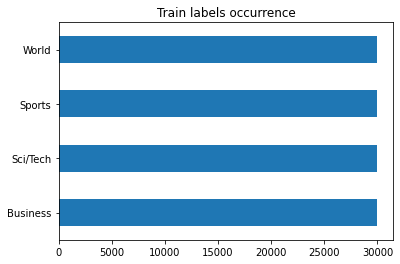

In [13]:
train_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Train labels occurrence")
plt.show()

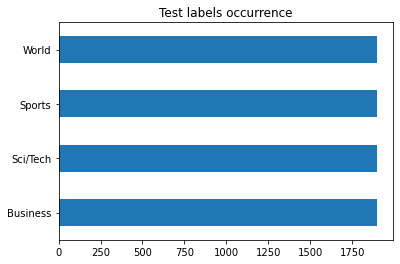

In [14]:
test_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Test labels occurrence")
plt.show()

Train and test datasets are perfectly balanced

In [15]:
train_df["input_num_words"] = train_df["text"].str.split().apply(len)
train_df.sample(5)

,text,label,label_name,input_num_words
17789,Can Microsoft Change Its DNA? Microsoft is in ...,3,Sci/Tech,39
32796,Jets C Mawae Breaks Right Hand (AP) AP - Jets ...,1,Sports,28
33617,Search for Amazon wreck victims Rescuers searc...,0,World,24
59258,Gaza schoolgirl dies of injuries A Palestinian...,0,World,24
27926,Leather industry under threat Despite rapid gr...,2,Business,34


In [16]:
test_df["input_num_words"] = test_df["text"].str.split().apply(len)
test_df.sample(5)

,text,label,label_name,input_num_words
7505,Boys 'cured' with gene therapy Gene therapy c...,0,World,25
3780,Russian Spacecraft Heads for International Spa...,3,Sci/Tech,31
6567,"Chip power, times 10 IBM, Sony Corp. and Toshi...",3,Sci/Tech,36
6230,"Holiday sales results lift Wal-Mart, Kmart Wal...",2,Business,48
5976,Olympic 2012 : Madrid unveils bid dossier Madr...,1,Sports,39


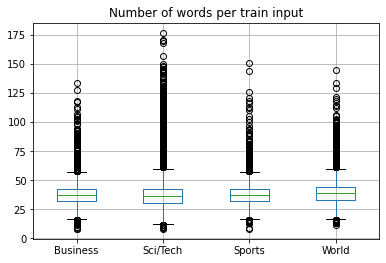

In [17]:
train_df.boxplot("input_num_words", by="label_name")
plt.title("Number of words per train input")
plt.suptitle("")
plt.xlabel("")
plt.show()

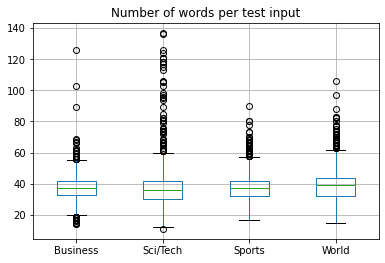

In [18]:
test_df.boxplot("input_num_words", by="label_name")
plt.title("Number of words per test input")
plt.suptitle("")
plt.xlabel("")
plt.show()

Number of words is quite evenly distributed

In [19]:
model_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [77]:
%%timeit

tokenized_train_text = tokenizer(train_df["text"].tolist())
tokenized_test_text = tokenizer(test_df["text"].tolist())

8.34 s ± 232 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [83]:
%%timeit

tokenized_train_text = tokenizer(train_df["text"].tolist())
tokenized_test_text = tokenizer(test_df["text"].tolist())

10.6 s ± 1.53 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [78]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
tokenized_dataset = dataset.map(tokenize, batched=True, batch_size=None)

In [22]:
tokenized_train_text.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [23]:
train_df["input_ids"] = tokenized_train_text["input_ids"]
train_df["token_type_ids"] = tokenized_train_text["token_type_ids"]
train_df["attention_mask"] = tokenized_train_text["attention_mask"]

In [24]:
train_df["tokens"] = train_df["input_ids"].apply(lambda y: tokenizer.convert_ids_to_tokens(y))

In [25]:
print(train_df["tokens"][0])

['[CLS]', 'wall', 'st', '.', 'bears', 'claw', 'back', 'into', 'the', 'black', '(', 'reuters', ')', 'reuters', '-', 'short', '-', 'sellers', ',', 'wall', 'street', "'", 's', 'd', '##wind', '##ling', '\\', 'band', 'of', 'ultra', '-', 'cy', '##nic', '##s', ',', 'are', 'seeing', 'green', 'again', '.', '[SEP]']


In [26]:
test_df["input_ids"] = tokenized_test_text["input_ids"]
test_df["token_type_ids"] = tokenized_test_text["token_type_ids"]
test_df["attention_mask"] = tokenized_test_text["attention_mask"]

In [27]:
test_df["tokens"] = test_df["input_ids"].apply(lambda y: tokenizer.convert_ids_to_tokens(y))

In [28]:
print(test_df["tokens"][0])

['[CLS]', 'fears', 'for', 't', 'n', 'pension', 'after', 'talks', 'unions', 'representing', 'workers', 'at', 'turner', 'new', '##all', 'say', 'they', 'are', "'", 'disappointed', "'", 'after', 'talks', 'with', 'stricken', 'parent', 'firm', 'federal', 'mo', '##gul', '.', '[SEP]']


In [29]:
train_df["input_num_tokens"] = train_df["tokens"].apply(len)

In [30]:
train_df[["input_num_tokens", "input_num_words"]].sample(5)

,input_num_tokens,input_num_words
118151,79,45
117229,41,32
72415,45,37
67013,37,31
9618,55,35


In [31]:
test_df["input_num_tokens"] = test_df["tokens"].apply(len)

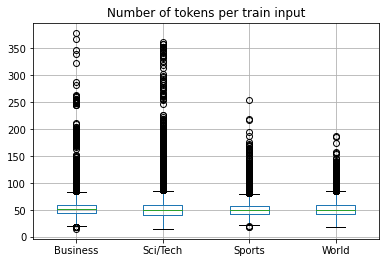

In [32]:
train_df.boxplot("input_num_tokens", by="label_name")
plt.title("Number of tokens per train input")
plt.suptitle("")
plt.xlabel("")
plt.show()

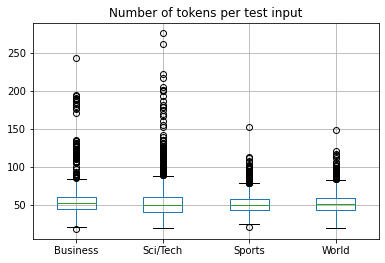

In [33]:
test_df.boxplot("input_num_tokens", by="label_name")
plt.title("Number of tokens per test input")
plt.suptitle("")
plt.xlabel("")
plt.show()

As expected, there are more tokens than words, as tokenization splits uncommon words to subwords. Good news is no example exceeds the model's maximum input length of 512 tokens.

In [34]:
concatenated_train_tokens = list(itertools.chain.from_iterable(train_df["tokens"]))

In [42]:
train_tokens_count_dict = dict(Counter(concatenated_train_tokens))

In [76]:
for token in sorted(tokens_count, key=tokens_count.get, reverse=True):
    print(token, tokens_count[token])

. 225971
the 205639
, 165685
- 139220
to 121526
[CLS] 120000
[SEP] 120000
a 113712
of 98774
in 97587
; 87360
and 69811
s 62461
on 57796
for 50852
# 47283
39 44543
( 41106
) 40787
##s 34025
' 32235
that 28200
as 27579
\ 26977
with 26899
& 26323
at 25379
is 22429
its 22138
new 21664
: 21530
it 21043
/ 20990
by 20988
said 20275
reuters 19340
has 19122
from 17830
an 17521
ap 16412
his 15017
after 14655
will 14626
was 13773
us 13386
gt 13287
lt 13213
" 13035
##t 12915
be 12735
over 11970
have 11223
up 11059
$ 10976
their 10531
two 10233
he 10092
first 9864
are 9817
year 9793
quo 9604
but 9190
more 9176
u 8742
world 8706
= 8441
1 8434
this 8252
##p 8229
one 8160
out 8076
company 7727
monday 7617
oil 7597
wednesday 7539
tuesday 7468
2 7365
thursday 7349
inc 7117
b 7107
not 7101
##ing 7065
against 6901
friday 6871
than 6794
into 6691
##er 6641
last 6565
they 6488
about 6428
iraq 6376
york 6336
no 6289
who 6145
yesterday 6118
t 6073
three 6042
microsoft 5998
president 5995
game 5838
were 5811
m

In [43]:
train_tokens_count_df = pd.DataFrame.from_dict({
    "token": train_tokens_count_dict.keys(),
    "count": train_tokens_count_dict.values()
})
train_tokens_count_df

,token,count
0,[CLS],120000
1,wall,1475
2,st,2300
3,.,225971
4,bears,402
...,...,...
25375,##cao,1
25376,##you,1
25377,patting,1
25378,annex,2


In [70]:
train_tokens_count_df.sort_values(by="count", ascending=False, inplace=True)
train_tokens_count_df = train_tokens_count_df.reset_index().drop(columns=["index"])
train_tokens_count_df

,token,count
0,.,225971
1,the,205639
2,",",165685
3,-,139220
4,to,121526
...,...,...
25375,whitley,1
25376,00pm,1
25377,sonata,1
25378,rourke,1


In [75]:
train_tokens_count_df.head(-1)

,token,count
0,.,225971
1,the,205639
2,",",165685
3,-,139220
4,to,121526
...,...,...
25374,repository,1
25375,whitley,1
25376,00pm,1
25377,sonata,1


In [41]:
train_df.drop(columns=["token_type_ids", "attention_mask"]).head()

,text,label,label_name,input_num_words,input_ids,tokens,input_num_tokens
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business,21,"[101, 2813, 2358, 1012, 6468, 15020, 2067, 204...","[[CLS], wall, st, ., bears, claw, back, into, ...",41
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business,36,"[101, 18431, 2571, 3504, 2646, 3293, 13395, 10...","[[CLS], carly, ##le, looks, toward, commercial...",53
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Business,36,"[101, 3514, 1998, 4610, 6112, 15768, 1005, 176...","[[CLS], oil, and, economy, cloud, stocks, ', o...",51
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Business,36,"[101, 5712, 9190, 2015, 3514, 14338, 2013, 236...","[[CLS], iraq, halt, ##s, oil, exports, from, m...",49
4,"Oil prices soar to all-time record, posing new...",2,Business,37,"[101, 3514, 7597, 2061, 2906, 2000, 2035, 1011...","[[CLS], oil, prices, so, ##ar, to, all, -, tim...",53
